This notebook demonstrates how to load the Objectron dataset on XLA devices 
(like TPU) using PyTorch/xla. Easiest way to run this notebook is on Colab with
TPU runtime.

<h3>  &nbsp;&nbsp;Use Colab Cloud TPU&nbsp;&nbsp; <a href="https://cloud.google.com/tpu/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/tpu-hexagon.png" width="50"></a></h3>

* On the main menu, click Runtime and select **Change runtime type**. Set "TPU" as the hardware accelerator.
* The cell below makes sure you have access to a TPU on Colab.

In [1]:
import os
assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

In [ ]:
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.6-cp36-cp36m-linux_x86_64.whl

In [ ]:
 # http://pytorch.org/xla/index.html#running-on-multiple-xla-devices-with-multithreading
 # http://pytorch.org/xla/index.html#running-on-multiple-xla-devices-with-multiprocessing

In [53]:
from PIL import Image
import numpy as np
import hashlib
import os
import sys
import torch
import io
import cv2

import torch

# imports the torch_xla package
import torch_xla
import torch_xla.core.xla_model as xm

import torch_xla.distributed.data_parallel as dp
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.distributed.parallel_loader as pl
import torch_xla.utils.tf_record_reader as tfrr

NUM_KEYPOINTS = 9

The `decode` function decodes a single tf.example file to a tuple of images/keypoints. Refer to the `objectron/dataset/schema/features.py` to see the list of all available features in the examples.

The points are reshaped as (`instance, point_id, [x,y,depth]`). Each annotated object has 9 keypoints, where 0 is the center of the box and the other 8 points are the box vertices. The `point_2d` feature contains the keypoints normalized $x-y$ value (so $x,y \in [0, 1]$) and the points depth from the center of the camera (in meters). You can also lookup the point's 3D coordinates in the camera system from `example['point_3d']` feature.

In [58]:
def decode(example):
  w = example['image/width'].item()
  h = example['image/height'].item()
  points = example['point_2d'].numpy()
  num_instances = example['instance_num'].item()
  points = points.reshape(num_instances, NUM_KEYPOINTS, 3)
  image_data = example['image/encoded'].numpy().tobytes()
  image = Image.open(io.BytesIO(image_data))
  npa = np.asarray(image)
  return torch.from_numpy(npa), points, num_instances

In [59]:
%matplotlib inline
# https://stackoverflow.com/questions/11159436/multiple-figures-in-a-single-window
import matplotlib.pyplot as plt

RADIUS = 10

colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (128, 128, 0), (128, 0, 128), 
          (0, 128, 128), (255, 255, 255), (0, 0, 0)]
EDGES = [
  [1, 5], [2, 6], [3, 7], [4, 8],  # lines along x-axis
  [1, 3], [5, 7], [2, 4], [6, 8],  # lines along y-axis
  [1, 2], [3, 4], [5, 6], [7, 8]   # lines along z-axis
]  

def show_3d_bounding_box(path, num_samples):
  count = 0
  transforms = {}  
  r = tfrr.TfRecordReader(path, compression='', transforms=transforms)
  fig, ax = plt.subplots(1, 10, figsize = (12, 16))
  
  for i in range(num_samples):
    example = r.read_example()
    if not example: break
    img_tensor, keypoints, num_instances = decode(example)
    image_clone = img_tensor

    for object_id in range(num_instances):
      w = 480
      h = 640
      for kp_id in range(NUM_KEYPOINTS):
        kp_pixel = keypoints[object_id, kp_id, :]
        cv2.circle(image_clone.numpy(), (int(w  * kp_pixel[0]), int(h * kp_pixel[1])), 
                  RADIUS, colors[object_id % len(colors)], -1)
      for edge in EDGES:
        start_kp = keypoints[object_id, edge[0], :]
        start_x = int(w * start_kp[0])
        start_y = int(h * start_kp[1])
        
        end_kp = keypoints[object_id, edge[1], :]
        end_x = int(w * end_kp[0])
        end_y = int(h * end_kp[1])

        cv2.line(image_clone.numpy(), (start_x, start_y), (end_x, end_y), 
                  colors[object_id % len(colors)], 1)
    ax[i].grid(False)
    ax[i].imshow(image_clone);
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)

  fig.tight_layout();
  plt.show()

The colab can directly load the samples from the tf.records in the objectron bucket. First, list the available tf.record shards for the category that we want. For example, for the cup category, the training data is located in `/cup/cup_train*` and the test data is available in `/cup/cup_test*`.

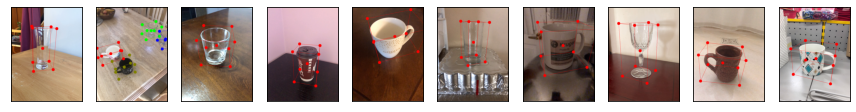

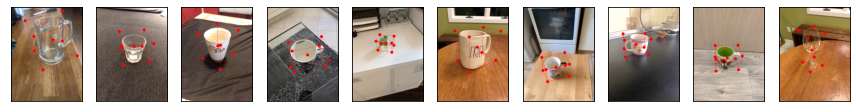

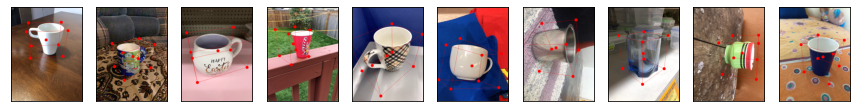

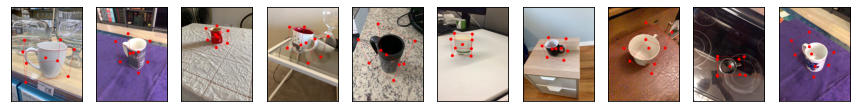

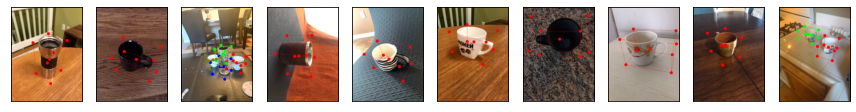

In [61]:
# We only use tensorflow for the glob function. 
import tensorflow as tf
objectron_buckett = 'gs://objectron/v1/records_shuffled'
training_shards   = tf.io.gfile.glob(objectron_buckett + '/cup/cup_train*')

for i in range(5):
  # Visualize the bounding box on the first 10 sample from this shard.
  show_3d_bounding_box(path = training_shards[i], num_samples = 10)